In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
import arch
import yfinance as yf
from arch import arch_model

## 1. Loading the data in dataframe from csv

In [110]:
# Read the CSV file 'BAJFINANCE.csv' into a DataFrame called 'data'
data = pd.read_csv('Data/BAJFINANCE.csv')

## 2. Plot the prices for the given data.

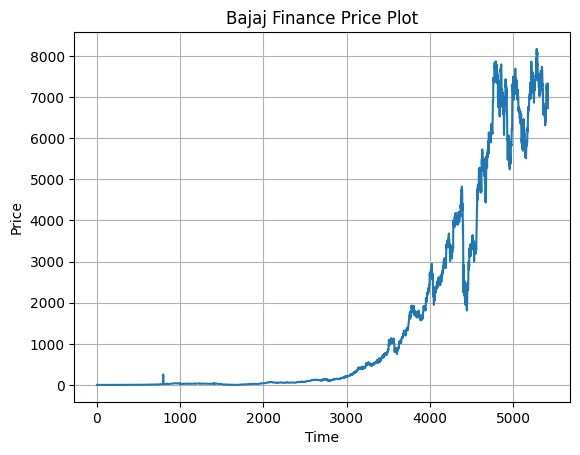

In [113]:
# Extract the 'Adj Close' column from the DataFrame and store it in the variable 'prices'
prices = data['Adj Close']
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bajaj Finance Price Plot')
plt.grid(True)
plt.show()

# X-axis contains dates in increasing order.

## 3. Plot log-returns for the given data.

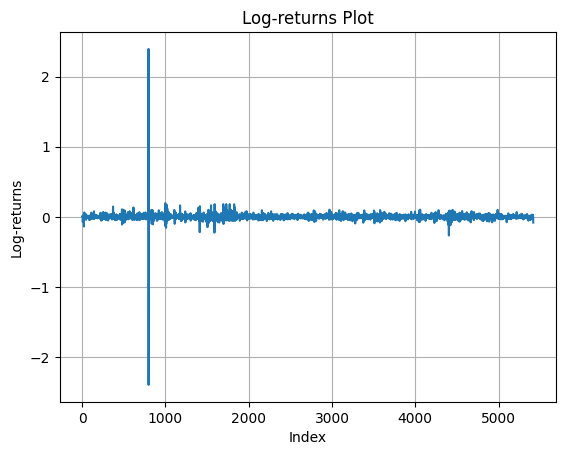

In [114]:
# Calculate the logarithmic returns by taking the logarithm of the ratio of prices
log_returns = np.log(prices / prices.shift(1)).dropna()

plt.plot(log_returns)
plt.xlabel('Index')
plt.ylabel('Log-returns')
plt.title('Log-returns Plot')
plt.grid(True)
plt.show()

## 4. Check whether log-returns are normally distributed using QQ plot, histogram and other statistical test like (Jerq-Berra, Kolmogorov-Smirno 
test)

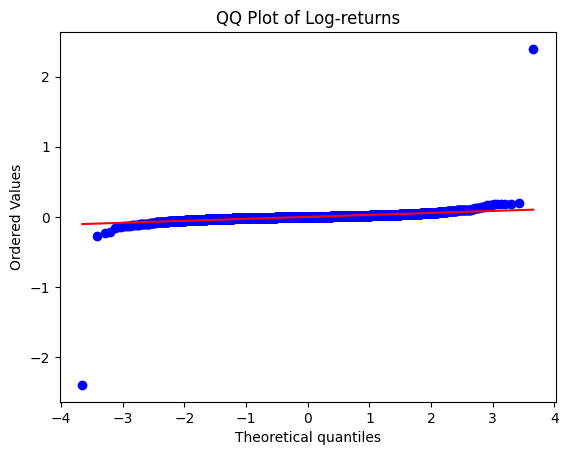

In [120]:
# Plot QQ plot
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Log-returns')
plt.show()

# This plot illustrates the distribution expected versus the actual distribution. So, we can conclude that it's not a perfectly normal distribution.

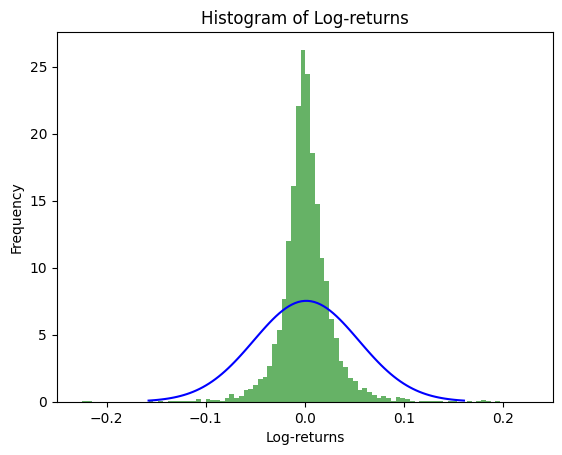

In [121]:
# Plot Histogram
plt.hist(log_returns, bins=1000, density=True, alpha=0.6, color='g')
mean = log_returns.mean()
std_dev = log_returns.std()
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
pdf_values = norm.pdf(x, loc=mean, scale=std_dev)
plt.plot(x, pdf_values, color='blue', label='Normal Distribution')
plt.title('Histogram of Log-returns')
plt.xlabel('Log-returns')
plt.ylabel('Frequency')
plt.xlim(-0.25, 0.25)
plt.show()

# This plot illustrates the distribution expected versus the actual distribution. So, we can conclude that it's not a perfectly normal distribution.

In [118]:
# Jarque-Bera test
jb_test = stats.jarque_bera(log_returns)
if jb_test[1] < 0.05:
    print("Log returns not normally distributed")
else:
    print("Log returns normally distributed")

# Test Result: Log returns not normally distributed

Log returns not normally distributed


In [117]:
# Kolmogorov-Smirnov test
ks_test = stats.kstest(log_returns, 'norm')
if ks_test.pvalue < 0.05:
    print("Log returns not normally distributed")
else:
    print("Log returns normally distributed")

# Test Result: Log returns not normally distributed

Log returns not normally distributed


Both Test shows not normally distributed as p value less than 0.05

## 5. Estimate the historical volatility using log returns.

In [42]:
# Assumption: To calculate the historical volatility we took a window of last 180 days.
historical_volatility = log_returns[-180:].std()
print("Historical volatility:", historical_volatility)
print("Annualised Historical volatility:", historical_volatility * np.sqrt(252)) # * sqrt(252) to convert into annualised volatility.

Historical volatility: 0.01536337893273344
Annualised Historical volatility: 0.24388607972196966


## 6. Risk free rate for INR = <span style="color:blue"> 6.88%</span>

## 7. Test the assumption if the log-returns are independent/uncorrelated.

In [122]:
# Assumption: for lags = 20
lb_test = acorr_ljungbox(log_returns, lags=20)  

if any(lb_test["lb_pvalue"] < 0.05):
   print("Conclusion: There is evidence to reject the null hypothesis. Log returns are dependent.")
else:
    print("Conclusion: There is not enough evidence to reject the null hypothesis. Log returns are likely independent.")

## Result: Log returns are dependent/correlated.

Conclusion: There is evidence to reject the null hypothesis. Log returns are dependent.


## 8, 9. Calculate the option price for an In-The-Money (ITM) European call option and In-The-Money European put option for the maturity May 31, 2024.

In [123]:
## For historical volatility: sigma = 0.243

In [124]:
# Function to calculate Black-Scholes call option price.
def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Function to calculate Black-Scholes put option price.
def black_scholes_put(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [125]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.243  # Volatility

bs_call_option_price = black_scholes_call(S, K_call, r, T, sigma)
bs_put_option_price = black_scholes_put(S, K_put, r, T, sigma)
print("Black Scholes Call Option Price", bs_call_option_price)
print("Black Scholes Put Option Price", bs_put_option_price)

Black Scholes Call Option Price 298.47184132024813
Black Scholes Put Option Price 271.73111135343106


In [127]:
# Function to calculate Cox-Ross-Rubinstein (CRR) call option price
def crr_call(S, K, r, T, sigma, steps=50):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Constructing the binomial tree for the stock prices
    stock_tree = np.zeros((steps + 1, steps + 1))
    stock_tree[0, 0] = S
    for i in range(1, steps + 1):
        stock_tree[i, 0] = stock_tree[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_tree[i, j] = stock_tree[i - 1, j - 1] * d

    # Calculate option price by backward induction
    option_tree = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        option_tree[steps, j] = max(0, stock_tree[steps, j] - K)

    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_tree[i, j] = np.exp(-r * dt) * (p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1])

    return option_tree[0, 0]
    
# Function to calculate Cox-Ross-Rubinstein (CRR) call option price
def crr_put(S, K, r, T, sigma, steps=50):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Constructing the binomial tree for the stock prices
    stock_tree = np.zeros((steps + 1, steps + 1))
    stock_tree[0, 0] = S
    for i in range(1, steps + 1):
        stock_tree[i, 0] = stock_tree[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_tree[i, j] = stock_tree[i - 1, j - 1] * d

    # Calculate option price by backward induction
    option_tree = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        option_tree[steps, j] = max(0, K - stock_tree[steps, j])

    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_tree[i, j] = np.exp(-r * dt) * (p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1])

    return option_tree[0, 0]

In [128]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.243  # Volatility

crr_call_option_price = crr_call(S, K_call, r, T, sigma)
crr_put_option_price = crr_put(S, K_put, r, T, sigma)
print("CRR Call Option Price", crr_call_option_price)
print("CRR Put Option Price", crr_put_option_price)

CRR Call Option Price 298.0741111609482
CRR Put Option Price 271.760825546654


In [129]:
# Function to simulate the price of a call option.
def simulate_call_option_price(S0, K_call, r, sigma, T, num_simulations=1000, display_graphs=False):
    dt = T / num_simulations
    n = int(T / dt)
    prices = np.zeros((num_simulations, n + 1))
    prices[:, 0] = S0

    # Simulate price paths using the Black-Scholes model
    for i in range(1, n + 1):
        z = np.random.normal(size=num_simulations)
        prices[:, i] = prices[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate option payoffs
    call_option_prices = np.maximum(0, prices[:, -1] - K_call)

    if display_graphs:
        for i in range(1000):
            plt.plot(prices[i])
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.title('Price Path for First 1000 Simulations (Call Option)')
        plt.show()

    # Calculate option price by taking the mean of option payoffs and discounting back to present value
    return np.mean(call_option_prices) * np.exp(-r * T)

# Define a function to simulate the price of a put option.
def simulate_put_option_price(S0, K_put, r, sigma, T, num_simulations=1000, display_graphs=False):
    dt = T / num_simulations
    n = int(T / dt)

    prices = np.zeros((num_simulations, n + 1))
    # Set initial prices equal to the current stock price
    prices[:, 0] = S0

    # Simulate price paths using the Black-Scholes model
    for i in range(1, n + 1):
        z = np.random.normal(size=num_simulations)
        prices[:, i] = prices[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    put_option_prices = np.maximum(0, K_put - prices[:, -1])

    if display_graphs:
        for i in range(1000):
            plt.plot(prices[i])
        # Add labels and title to the plot
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.title('Price Path for First 1000 Simulations (Put Option)')
        plt.show()

    # Calculate option price by taking the mean of option payoffs and discounting back to present value
    return np.mean(put_option_prices) * np.exp(-r * T)

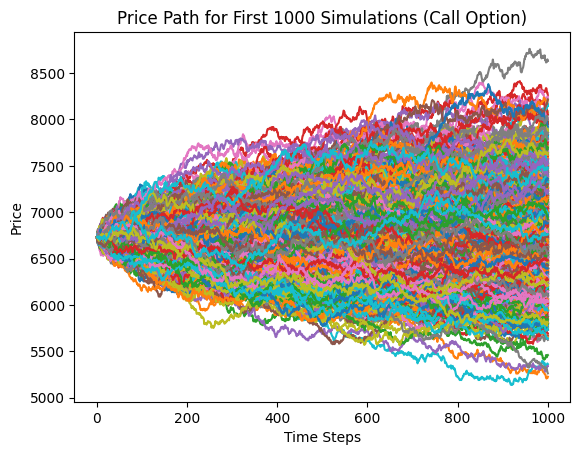

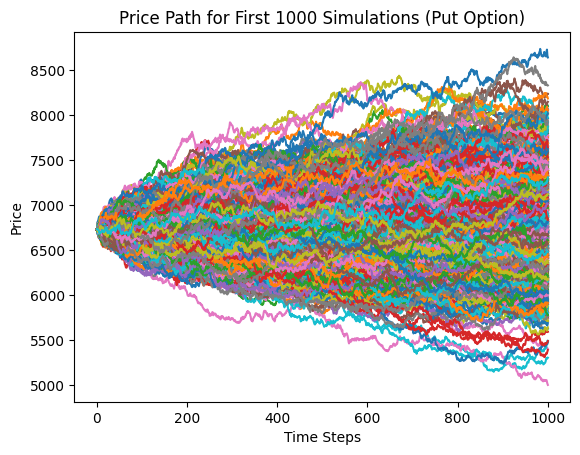

Simulation Call Option Price: 295.0107303876221
Simulation Put Option Price: 259.7312130551393


In [130]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.243  # Volatility

call_option_price = simulate_call_option_price(S, K_call, r, sigma, T, display_graphs=True)
put_option_price = simulate_put_option_price(S, K_put, r, sigma, T, display_graphs=True)

print("Simulation Call Option Price:", call_option_price)
print("Simulation Put Option Price:", put_option_price)

## 10. Estimate the <span style="color:blue">GARACH</span> volatility methods.

In [98]:
# Function to estimate volatility using GARCH model with rescaling
def estimate_volatility_garch(symbol, start_date, end_date, scaling=7.5):
    
    # Download adjusted close prices data for the given symbol and time period
    data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']
    returns = np.log(data / data.shift(1)).dropna()
    returns_rescaled = scaling * returns

    model = arch.arch_model(returns_rescaled, vol='Garch', p=1, q=1, rescale=False)
    results = model.fit(disp='off')
    forecast_volatility = results.forecast(horizon=1).variance.iloc[-1, 0]
    
    # Return the square root of the forecasted volatility as the estimated volatility
    return np.sqrt(forecast_volatility)

In [132]:
symbol = 'BAJFINANCE.NS'  
start_date = '2002-07-02'  
end_date = '2024-04-26' 

volatility_garch = estimate_volatility_garch(symbol, start_date, end_date)
print("Estimated volatility using GARCH model:", volatility_garch)

[*********************100%%**********************]  1 of 1 completed

Estimated volatility using GARCH model: 0.25540019170960077


In [143]:
## For historical volatility: sigma = 0.255

In [140]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.255  # Volatility

bs_call_option_price = black_scholes_call(S, K_call, r, T, sigma)
bs_put_option_price = black_scholes_put(S, K_put, r, T, sigma)
print("Black Scholes Call Option Price", bs_call_option_price)
print("Black Scholes Put Option Price", bs_put_option_price)

Black Scholes Call Option Price 307.7594034539802
Black Scholes Put Option Price 281.5155540590563


In [141]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.255  # Volatility

crr_call_option_price = crr_call(S, K_call, r, T, sigma)
crr_put_option_price = crr_put(S, K_put, r, T, sigma)
print("CRR Call Option Price", crr_call_option_price)
print("CRR Put Option Price", crr_put_option_price)

CRR Call Option Price 307.61991769837357
CRR Put Option Price 281.2262922725636


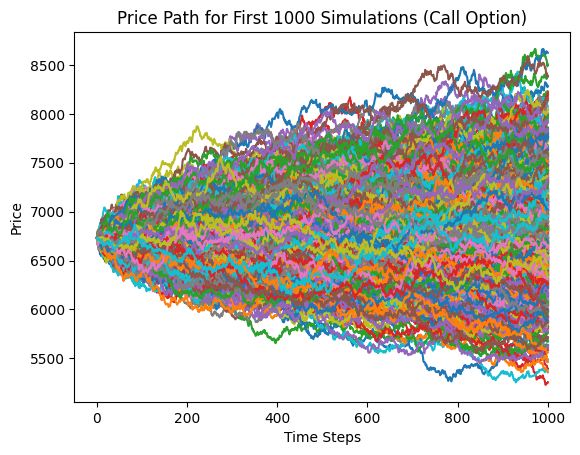

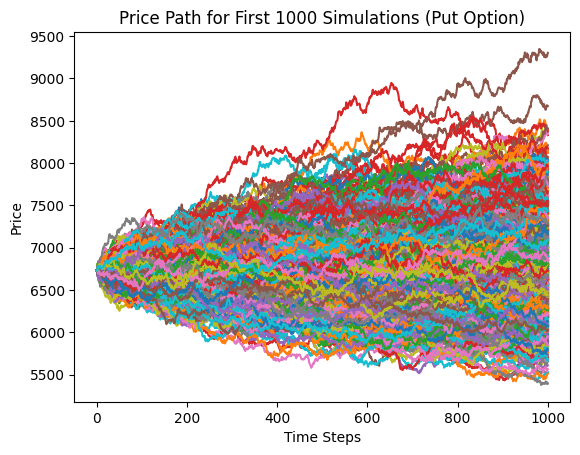

Simulation Call Option Price: 305.31686452568033
Simulation Put Option Price: 275.0468796380896


In [142]:
# Today's date = 26/04/2024
S = 6730.80    # Current stock price.
K_call = 6600  # In the money strike for call.
K_put = 6900   # In the money strike for put.
r = 0.0688     # Risk free rate.
T = 35/365     # Time
sigma = 0.255  # Volatility

call_option_price = simulate_call_option_price(S, K_call, r, sigma, T, display_graphs=True)
put_option_price = simulate_put_option_price(S, K_put, r, sigma, T, display_graphs=True)

print("Simulation Call Option Price:", call_option_price)
print("Simulation Put Option Price:", put_option_price)

## Results:

Today's date: 26/04/2024

Underlying Price: 6730.80

In the Money Call Strike: 6600

In the Money Put Strike: 6900

Actual Call Option Strike price (K=6600): 295.80

Actual Put Option Strike Price (K=6900): 279.00

Historical Volatility (sigma): 0.243

Forecaset Volatility using Garach (sigma): 0.255

Risk free rate for INR = 6.88%

| Model | volatility type | call | put |
|---| ---| ---|---|
| Black-Scholes | Historical | 298.47 | 271.73 |
| CRR | Historical | 298.07 | 271.76 |
| Simulation | Historical | 295.01 | 259.73 |
| Black-Scholes | Forecasted | 307.75 | 281.51 |
| CRR | Forecasted | 307.61 | 281.22 |
| Simulation | Forecasted | 303.50 | 275.04 |3 |  |12  |
